Mean of the simulated contract prices: 0.3010938245846744
90% confidence interval for simulated contract prices: [0.26168476 0.34646813]


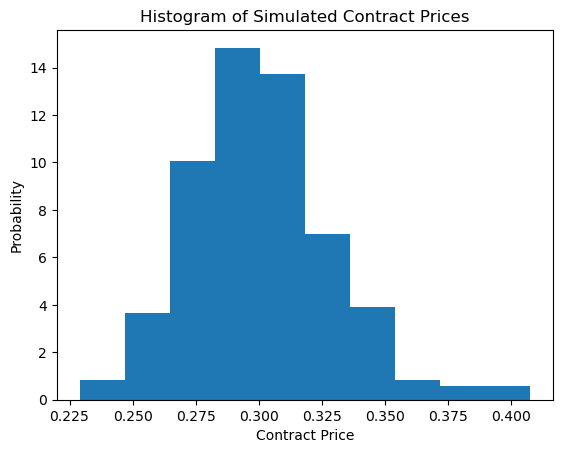

In [74]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to generate Libor paths
def generate_libor_paths(libor_init, time_to_maturity, libor_volatility, time_steps, num_trials):
    dt = time_to_maturity / time_steps
    libor_paths = np.log(libor_init) + np.cumsum(
        ((-libor_volatility ** 2 / 2) * time_to_maturity + libor_volatility * np.sqrt(time_to_maturity) * 
        np.random.normal(size=(time_steps, num_trials))), axis=0)
    return np.exp(libor_paths)

# Function to generate quanto paths
def generate_quanto_paths(stock_price_init, time_to_maturity, risk_free_rate, dividend_rate, stock_volatility, 
                          exchange_rate_volatility, bond_volatility, correlation1, correlation2, time_steps, num_trials):
    dt = time_to_maturity / time_steps
    quanto_paths = np.log(stock_price_init) + np.cumsum(
        ((risk_free_rate - dividend_rate - stock_volatility * exchange_rate_volatility * correlation1 + 
        correlation2 * bond_volatility * stock_volatility - stock_volatility ** 2 / 2) * dt +
        stock_volatility * np.sqrt(time_to_maturity) * np.random.normal(size=(time_steps, num_trials))), axis=0)
    return np.exp(quanto_paths)

# Function to calculate price
def calculate_price(strike_price):
    # Define parameters
    libor_init = 4.767
    stock_price_init = 26094.5
    time_to_maturity = 3
    risk_free_rate = -0.01
    dividend_rate = 0.015
    stock_volatility = 0.01374056296970254
    exchange_rate_volatility = 0.0051993926383636846
    bond_volatility = 0.20803601447114695
    libor_volatility = 0.03546174166625594
    correlation1 = 0.7745361023076186
    correlation2 = 0.6234974594550516
    time_steps = 252 * time_to_maturity
    num_trials = 1000
    time_delta = 0.75

    # Generate paths
    quanto_paths = generate_quanto_paths(stock_price_init, time_to_maturity, risk_free_rate, dividend_rate, 
                                         stock_volatility, exchange_rate_volatility, bond_volatility, 
                                         correlation1, correlation2, time_steps, num_trials)
    libor_paths = generate_libor_paths(libor_init, time_to_maturity - time_delta, libor_volatility, time_steps, num_trials)

    final_quanto_price = quanto_paths[-1]
    final_libor_price = libor_paths[-1]

    payoff = (strike_price - final_libor_price / libor_init) * (final_quanto_price / stock_price_init - 1)
    payoff[payoff < 0] = 0  # Apply payoff function max(0, payoff)

    return np.mean(payoff)

# Simulate contract prices
simulated_prices = [calculate_price(1) for _ in range(200)]
print(f"Mean of the simulated contract prices: {np.mean(simulated_prices)}")
# Print 90% confidence interval for simulated contract prices
confidence_interval = np.percentile(simulated_prices, [5, 95])
print(f"90% confidence interval for simulated contract prices: {confidence_interval}")

# Plot histogram of simulated contract prices
plt.hist(simulated_prices, density=True, bins=10)
plt.title("Histogram of Simulated Contract Prices")
plt.ylabel('Probability')
plt.xlabel('Contract Price')
plt.savefig("image/Simulated_Contract_Price_Histogram.pdf")


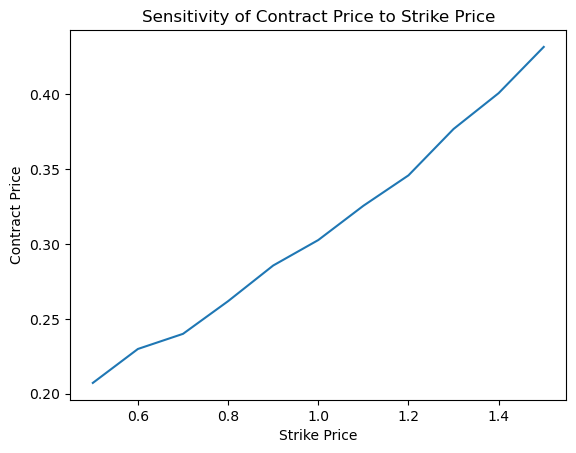

In [75]:
# Perform sensitivity analysis on strike price
strike_prices = [0.5 + j * 0.1 for j in range(11)]
simulated_prices_per_strike = [calculate_price(strike) for strike in strike_prices for _ in range(100)]

# Calculate mean contract price for each strike price
mean_prices_per_strike = [np.mean(simulated_prices_per_strike[i*100 : (i+1)*100]) for i in range(11)]

# Plot sensitivity of contract price to strike price
plt.plot(strike_prices, mean_prices_per_strike)
plt.title("Sensitivity of Contract Price to Strike Price")
plt.ylabel('Contract Price')
plt.xlabel('Strike Price')
plt.savefig("image/Sensitivity_to_Strike_Price.pdf")

